<a href="https://colab.research.google.com/github/DevMed22/Revive_My_Memory/blob/model/models/mci_classification_model_FirstSprint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://www.bu.edu/files/2022/07/feat-crop-iStock-1026002288.jpg" width=70%/>


**Alzheimer's disease** is a condition where neurons within the brain stop functioning, lose connection with other neurons and die. It's the most common cause of dementia, a loss of brain function that can adversely impact memory, thinking, language, judgment and behavior. Alzheimer's is irreversible and progressive.

Alzheimer's is evaluated by identifying certain symptoms and ruling out other possible causes of dementia. Your doctor will likely perform a complete medical exam, including neurological, blood and brain imaging exams, such as CT, MRI or PET/CT of the head. There is no cure for Alzheimer's disease. However, your doctor may prescribe medication to slow the disease's progression and manage your symptoms.

**MRI of the head**: Magnetic resonance imaging (MRI) uses a powerful magnetic field, radio frequency pulses and a computer to produce detailed pictures of organs, soft tissues, bone and virtually all other internal body structures. MRI can detect brain abnormalities associated with mild cognitive impairment (MCI) and can be used to predict which patients with MCI may eventually develop Alzheimer's disease. In the early stages of Alzheimer's disease, an MRI scan of the brain may be normal. In later stages, MRI may show a decrease in the size of different areas of the brain (mainly affecting the temporal and parietal lobes).

## In this NoteBook

**In this NoteBook**, a convolutional neural network (CNN)-based Alzheimer MRI images classification algorithm is developed using **ResNet152V2** architecture, to detect **"Mild Demented"**, **"Moderate Demented"**, **"Non Demented"** and **"Very Mild Demented"** in patient's MRI.

# 1. Importing Libraries

In [40]:
!pip install pydicom
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
import os
import pydicom
import numpy as np
import pandas as pd
import splitfolders
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import applications
from PIL import Image
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [24]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
    
from helper_functions import plot_loss_curves

--2023-02-13 22:02:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-13 22:02:41 (61.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# 2. Uploading the Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
SAMPLE_PER_CATEGORY = 200
SEED = 42
WIDTH = 128
HEIGHT = 128
DEPTH = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)


## Splitting the data into train and valid 

In [6]:
input_folder = "/content/drive/MyDrive/ADNI_data/data_model/data"
output = "/content/drive/MyDrive/ADNI_data/data_model/splitted_data" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.7, .3))

Copying files: 4830 files [04:58, 16.18 files/s]


In [36]:
data_dir='/content/drive/MyDrive/ADNI_data/data_model/splitted_data'
train_dir='/content/drive/MyDrive/ADNI_data/data_model/splitted_data/train'
test_dir='/content/drive/MyDrive/ADNI_data/data_model/splitted_data/val'

##  Defining Categories

In [59]:
CATEGORIES = ['CN','EMCI']
NUM_CATEGORIES = len(CATEGORIES)
NUM_CATEGORIES

2

### Calculating the number of images in each category in training data

In [60]:
import os
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

CN 750 images
EMCI 2630 images


# Converting DICOM to jpg

In [89]:
!pip install dicom2jpg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 30.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.2 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.


In [101]:
import dicom2jpg
# convert all DICOM files in dicom_dir folder to png format
dicom2jpg.dicom2jpg(data_dir)

True

# 4. Creating Train and Validation DataFrame

In [91]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.shape

(3380, 3)

In [92]:
train = train.sample(frac=1)
X = train.drop(columns = 'category_id')
y = train['category_id']

In [93]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=4)

In [94]:
train = pd.concat([x_train, y_train], axis=1)
validation = pd.concat([x_valid, y_valid], axis=1)

In [95]:
train = train.reset_index()
train = train.drop(columns = 'index')
validation = validation.reset_index()
validation = validation.drop(columns = 'index')
print(train.shape)
print(validation.shape)

(2704, 3)
(676, 3)


In [96]:
train.head()

,file,category,category_id
0,train/EMCI/ADNI_002_S_2010_MR_MPRAGE_br_raw_20...,EMCI,1
1,train/CN/ADNI_002_S_0413_MR____________MPRAGE_...,CN,0
2,train/CN/ADNI_002_S_0413_MR_MPRAGE_br_raw_2007...,CN,0
3,train/EMCI/ADNI_002_S_2010_MR_Field_Mapping__b...,EMCI,1
4,train/EMCI/ADNI_002_S_2010_MR_MPRAGE_br_raw_20...,EMCI,1


In [97]:
validation.head()

,file,category,category_id
0,train/EMCI/ADNI_002_S_2010_MR_MPRAGE_SENSE2__b...,EMCI,1
1,train/EMCI/ADNI_002_S_2010_MR_MPRAGE_br_raw_20...,EMCI,1
2,train/EMCI/ADNI_002_S_2010_MR_MPRAGE_br_raw_20...,EMCI,1
3,train/EMCI/ADNI_002_S_2010_MR_Axial_T2-FLAIR_b...,EMCI,1
4,train/EMCI/ADNI_002_S_2010_MR_SURVEY_br_raw_20...,EMCI,1


# 5. Creating Test DataFrame

In [98]:
test = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(test_dir, category)):
        test.append(['val/{}/{}'.format(category, file), category_id, category])
test = pd.DataFrame(test, columns=['file', 'category_id', 'category'])
test.shape

(1450, 3)

# 6. Demonstrating Example Images

In [77]:
def read_dcm(filepath):
    img = pydicom.read_file(os.path.join(data_dir, filepath))
    img = img.pixel_array
    return img

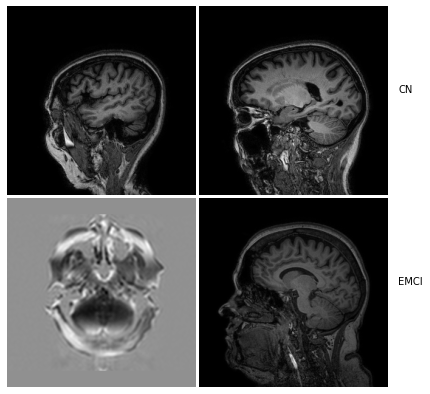

In [80]:
fig = plt.figure(1, figsize=(7, 7))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)

i=0    
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_dcm(filepath)
        ax.imshow(img / 255.,cmap='gray')
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(270, 112, filepath.split('/')[1], verticalalignment='center')
        i+=1
        
plt.show();

# 7. Keras ImageDataGenerator

In [87]:
!pip install git+git://github.com/keras-team/keras-preprocessing.git --upgrade -- no-deps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning git://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-e4pscy5x
  Running command git clone --filter=blob:none --quiet git://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-e4pscy5x
  fatal: unable to connect to github.com:
  github.com[0: 140.82.112.3]: errno=Connection timed out

  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet git://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-e4pscy5x did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet git://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-e4pscy5x did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error orig

convert dcm files to pixels

In [107]:
X_train_data = []
y_train_data = []

# Iterate through the rows of the 'positive' DF
count = 0
# for index, row in x_train.iterrows():
#     img = pydicom.dcmread(data_dir+'/'+x_train['file'][index])
#     pixels = img.pixel_array
#     X_train_data.append(pixels)
        
for index in y_train:
    y_train_data.append(y_train['category_id'][index])



KeyError: ignored

In [100]:
datagen_train = ImageDataGenerator(rescale=1./255)
train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                                  directory=data_dir,
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32,
                                                  seed=SEED,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

validation_generator = datagen_train.flow_from_dataframe(dataframe=validation,
                                                  directory=data_dir,
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32,
                                                  seed=SEED,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


In [ ]:
datagen_test = ImageDataGenerator(rescale=1./255)
test_generator = datagen_test.flow_from_dataframe(dataframe=test,
                                                  directory="../input/augmented-alzheimer-mri-dataset-v2/data",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32,
                                                  seed=SEED,
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

Found 6400 validated image filenames belonging to 4 classes.


# 8. Early Stopping

In [72]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# 9. Creating Model based on ResNet152V2

In [73]:
def create_model():
   
    resnet_model = tf.keras.applications.resnet_v2.ResNet152V2(
        weights='imagenet',
        include_top = False,
        input_shape = (224, 224, 3)
    )
    
    for layers in resnet_model.layers[:100]:
        layers.trainable = False
    for layers in resnet_model.layers[100:]:
        layers.trainable = True

    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    # output layer
    predictions = tf.keras.layers.Dense(4, activation='softmax')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compiling the model
    res_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return res_model

In [74]:
res_model = create_model()

234545216/234545216 [==============================] - 2s 0us/step


In [75]:
res_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# 10. Training the Model

In [76]:
history = res_model.fit(train_generator,
                    epochs=500, 
                    steps_per_epoch=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping],
                    batch_size=32)

IndexError: ignored

### Plotting the history of model

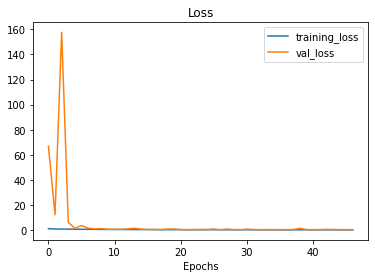

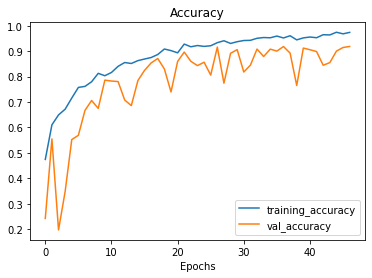

In [ ]:
plot_loss_curves(history)

# 10. Evaluation

In [ ]:
valid_loss, valid_accuracy = res_model.evaluate(validation_generator)

print(f'\nTrain loss: {valid_loss:.2f}')
print(f'Train Accuracy: {valid_accuracy*100:.2f} %')

213/213 [==============================] - 14s 67ms/step - loss: 0.2512 - accuracy: 0.9185

Train loss: 0.25
Train Accuracy: 91.85 %


In [ ]:
loss, accuracy = res_model.evaluate(test_generator)

print(f'\nTest loss: {loss:.2f} ')
print(f'Test Accuracy: {accuracy*100:.2f} %')

200/200 [==============================] - 16s 79ms/step - loss: 0.0853 - accuracy: 0.9731

Test loss: 0.09 
Test Accuracy: 97.31 %


In [ ]:
y_predict = res_model.predict(test_generator)
prediction = np.argmax(y_predict,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
prediction = [labels[k] for k in prediction]

y_test = list(test.category)

report = classification_report(y_test, prediction, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
MildDemented,0.996587,0.977679,0.987042,896.000000
ModerateDemented,1.000000,1.000000,1.000000,64.000000
NonDemented,0.958635,0.992188,0.975123,3200.000000
VeryMildDemented,0.985082,0.943304,0.963740,2240.000000
accuracy,0.973125,0.973125,0.973125,0.973125
macro avg,0.985076,0.978292,0.981476,6400.000000
weighted avg,0.973618,0.973125,0.973056,6400.000000
